In [21]:
import chemfold as cf
from scipy.sparse import csr_matrix
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
import matplotlib.pyplot as plt
from itertools import combinations

# Check distance distribution to closest drug 

In [22]:
def compute_tanimoto_distance_from_df(df):
    """
    Computes Tanimoto distance between all pairs of SMILES strings in a DataFrame.

    Parameters:
    - df: DataFrame with SMILES strings in a column.

    Returns:
    - distances_df: DataFrame containing Tanimoto distances between all pairs of SMILES strings.
    """
    # Convert SMILES strings to RDKit Mol objects
    mols = [Chem.MolFromSmiles(smiles) for smiles in df['SMILES']]

    # Calculate fingerprints for each molecule
    fps = [AllChem.GetMorganFingerprint(mol, 2) for mol in mols]

    # Compute Tanimoto distance between all pairs of fingerprints
    distances = []

    similarity_df = pd.DataFrame(index=df.index, columns=df.index)
    for i, j in combinations(range(len(df)), 2):
        tanimoto_similarity = DataStructs.TanimotoSimilarity(fps[i], fps[j])
        similarity_df.at[df.index[i], df.index[j]] = tanimoto_similarity
        similarity_df.at[df.index[j], df.index[i]] = tanimoto_similarity
    return similarity_df.fillna(1.0)

In [25]:
bbbc021_index = pd.read_csv("/lustre/groups/ml01/workspace/alessandro.palma/imCPA_official/data/bbbc021_unannotated/processed/bbbc021_unannotated_large/metadata/bbbc021_unannotated_large.csv",
                           index_col=0)
# bbbc021_index = pd.read_csv("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/bbbc021_all/metadata/bbbc021_df_all.csv",
#                            index_col=0)

drugs_annotated = np.unique(bbbc021_index.CPD_NAME)

In [26]:
metadata_unique = bbbc021_index[["CPD_NAME", "SMILES"]]
metadata_unique = metadata_unique.drop_duplicates(subset="CPD_NAME").set_index("CPD_NAME", drop=True)

tanimoto_distance_matrix = compute_tanimoto_distance_from_df(metadata_unique)

mat_tani_second_highest_val = tanimoto_distance_matrix.apply(lambda row: row.nlargest(2).iloc[-1], axis=1)
mat_tani_second_highest_cpd = tanimoto_distance_matrix.apply(lambda row: row.nlargest(2).index[-1], axis=1)

mat_tani_second_highest_val

CPD_NAME
5-fluorouracil    0.272727
acyclovir         0.211111
AG-1478           0.333333
ALLN              0.820513
aloisine A        0.271845
                    ...   
AZ138             0.245283
AZ701             0.333333
AZ258             0.903509
AZ841             0.903509
DMSO              0.096774
Length: 99, dtype: float64

In [32]:
mat_tani_second_highest_val["cytochalasin B"]

0.5426356589147286

(array([ 1.,  3.,  1.,  5., 21., 19., 14.,  4.,  0.,  2.,  3.,  3.,  2.,
         0.,  5.,  6.,  4.,  0.,  4.,  2.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

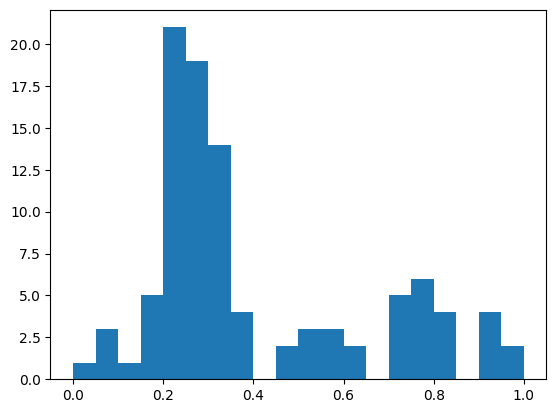

In [27]:
plt.hist(mat_tani_second_highest_val, 20)

In [6]:
mat_tani_second_highest_val.mode()

0    0.210084
1    0.281818
2    0.542636
3    0.578947
4    0.726316
5    0.780220
6    0.845238
7    0.903509
dtype: float64

In [7]:
mat_tani_second_highest_val.mean()

0.395348273798481

## Read data frame 

In [8]:
drug_smiles = pd.read_csv("/home/icb/alessandro.palma/environment/IMPA/IMPA/embeddings/csv/emb_fp_all.csv", 
                         index_col=0)

In [9]:
drug_names = list(drug_smiles.index)
drug_smiles_csr = csr_matrix(drug_smiles.values)
# cl_hier = cf.hierarchical_clustering(drug_smiles_csr, dists=[0.2,0.4,0.6,0.8])
cl_hier = cf.hierarchical_clustering(drug_smiles_csr, dists=[0.50,0.60,0.70])

clusters_2_drug = {}

Row 0.
Reassigning compounds to the closest clusters.
Row 0.
Reassignement changed 0 assignments.
Total 84 clusters.
Row 0.
Reassigning compounds to the closest clusters.
Row 0.
Reassignement changed 0 assignments.
Total 81 clusters.
Row 0.
Reassigning compounds to the closest clusters.
Row 0.
Reassignement changed 0 assignments.
Total 77 clusters.


/tmp/ipykernel_2369303/285779884.py:4: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  cl_hier = cf.hierarchical_clustering(drug_smiles_csr, dists=[0.50,0.60,0.70])


## Read annotated data frame 

In [10]:
annotation = pd.read_csv("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/bbbc021_all/metadata/bbbc021_df_all.csv")

In [11]:
valid_cpd = np.unique(annotation.CPD_NAME)

## Perform separation

In [12]:
for i, clus in enumerate(cl_hier):
    if clus not in clusters_2_drug:
        clusters_2_drug[clus] = []
    clusters_2_drug[clus].append(drug_names[i])

In [13]:
c = 0
for i in clusters_2_drug:
    if len(clusters_2_drug[i]) > 1:
        print(clusters_2_drug[i])
        c+=1
c

['AG-1478', 'AZ701']
['ALLN', 'calpain inhibitor 2 (ALLM)', 'calpeptin', 'caspase inhibitor 1 (ZVAD)', 'leupeptin', 'MG-132', 'proteasome inhibitor I']
['arabinofuranosylcytosine', 'puromycin']
['bohemine', 'olomoucine', 'roscovitine']
['colchicine', 'demecolcine']
['cytochalasin B', 'cytochalasin D']
['deoxymannojirimycin', 'deoxynojirimycin']
['docetaxel', 'taxol']
['etoposide', 'podophyllotoxin']
['genistein', 'quercetin']
['mevinolin/lovastatin', 'simvastatin']
['PD-169316', 'SB-202190', 'SB-203580']
['sodium butyrate', 'valproic acid']
['vinblastine', 'vincristine']
['AZ258', 'AZ841']


15

In [14]:
# leavouts = []
# np.random.seed(42)
# for i in clusters_2_drug:
#     if len(clusters_2_drug[i]) > 1:
#         leavouts.append(np.random.choice(clusters_2_drug[i]))

# leavouts

## Try Splito

### Scaffold

In [15]:
import splito

In [16]:
unique_smiles = np.unique(bbbc021_index.SMILES)
smiles2drug = dict(zip(bbbc021_index.SMILES, bbbc021_index.CPD_NAME))

In [17]:
# Define scaffold split
splitter = splito.ScaffoldSplit(smiles=unique_smiles.tolist(), n_jobs=-1, test_size=0.27, random_state=55)

In [18]:
train_idx, test_idx = next(splitter.split(X=unique_smiles))

In [19]:
for sm in unique_smiles[test_idx]:
    print(smiles2drug[sm])

taxol
ALLN
bryostatin
camptothecin
demecolcine
nocodazole
colchicine
DMSO
cytochalasin B
latrunculin B
cisplatin


In [20]:
for sm in unique_smiles[test_idx]:
    print(smiles2drug[sm])

taxol
ALLN
bryostatin
camptothecin
demecolcine
nocodazole
colchicine
DMSO
cytochalasin B
latrunculin B
cisplatin
